This notebook is an introduction to 1D data analysis using [continuous wavelet transform](https://en.wikipedia.org/wiki/Continuous_wavelet_transform) (CWT).

You will find here:
* How to compute a scaleogram which is a 2D view of 1D time ordered data
* A guided tour of the zoo: how basic data appears on this kind of spectrogram
* Apply the methodology to an example dataset

The python module used for the examples is `scaleogram`. 

# Introduction

Recently I had to do a preliminatory analysis on birth data. I wanted to use continuous wavelet transform to plot a spectrum of the dataset to get quick insights. Wavelets are specially well suited for this job. I expected to be able from **python** to do something like `view(data, scales)`,  and get a plot with *meaningful* labels on the axis.  As I did not used wavelets for quite some time, it did not went that way and I spent quite a long time to get painfully some visualization with the Y axis labelled either in frequency or periods units. Very frustrating!

Hence as wavelets should be easyly accessible from python I wrote a simple PyPi module `scaleogram` dedicated to plot the continuous wavelet transform.  It has been written to be easily accessible to complete beginners, provide usefull error  messages and packed with online help explaining what is computed under the hood. The following examples are based on this module.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# currently (03/2019) scaleogram needs install via https://github.com/alsauve/scaleogram
# because an old PyWavelets (0.5.2) is installend and PyWavelets > 1.0 is needed
import scaleogram as scg 
import pywt

# choose default wavelet function for the entire notebook
scg.set_default_wavelet('cmor1-1.5')

# Try these ones to see various compromises between scales and time resolution 
#scg.set_default_wavelet('cgau5')
#scg.set_default_wavelet('cgau1')
#scg.set_default_wavelet('shan0.5-2')
#scg.set_default_wavelet('mexh')

## What is a scaleogram?

In the wavelet formalism, a scaleogram is a 2D representation of 1D data with
* On the X axis the time
* On the Y axis the scale   
    The scale correspond to the signal periodicity to which the transform is sentitive to.  
* The value correspond to the amplitude of the signal variation measured  
    These variations are located at time X  and have a periodicity Y

This  kind of plot is a special kind of [spectrogram](https://en.wikipedia.org/wiki/Spectrogram), but in the case of wavelet the resolution in time vary with the scale value on the Y axis. 

But let's look right now to a scaleogram of simple signals.


## How periodic variations displays on a scaleogram?

For the first example, the signal generated is a *cos* wave with a gaussian envelop. The signal sampling is set at 1 sample / second (which means no time array is provided).


Default wavelet function used to compute the transform: cmor1-1.5 ( Complex Morlet wavelets )


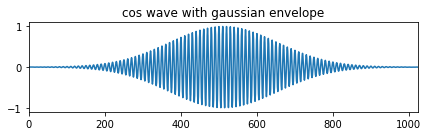

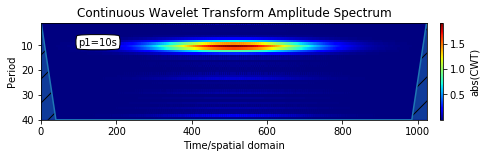

In [2]:
# let consider a timeline with 1 sample / second
ns   = 1024
time = np.arange(ns)

# and a range of scales to perform the transform
scales = scg.periods2scales( np.arange(1, 40) )

# and a periodic signal with varying amplitude
p1=10; periodic1 = np.cos(2*np.pi/p1*time) * np.exp(-((time-ns/2)/200)**2)

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(6.2,2));  
lines = ax1.plot(periodic1); 
ax1.set_xlim(0, len(time))
ax1.set_title("cos wave with gaussian envelope")
fig1.tight_layout()

# and the scaleogram
ax2 = scg.cws(periodic1, scales=scales, figsize=(6.9,2.3)); 
txt = ax2.annotate("p1=10s", xy=(100, 10), bbox=dict(boxstyle="round4", fc="w"))
plt.tight_layout()

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")

The periodic signal appear now as an **horizontal continuous stripe** at location *Y=p1*, which intensity vary with the amplitude of the periodic signal. You can observe some fuzzyness in the detection as the band width is not null, this is due to the fact that wavelets does not detect a single frequency but rather a *band*. It appears visually as the width of the band on the *Y* axis. This effect is related to the *bandwidth* of the wavelet.

In other words the CWT measure
* the periodicity (Y axis) of a signal at a given location (X axis)
* the amplitude of the oscillations (Z axis)

Ok until now? Then let's test with some other signals!

## Periodic varitions at different scales : multiresolution analysis

For the next example, 3 pulses with increasing periodicity are added on the data with 
* $p1=10s$ 
* $p2=2*p1$ 
* $p3=4*p1$

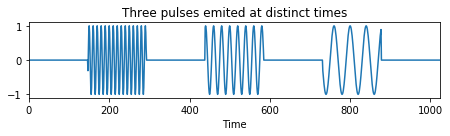

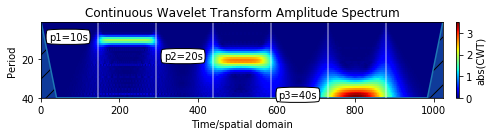

In [3]:
pulses = np.zeros(ns, dtype=np.float32)
steps  = np.linspace(0, ns, 8)
periods = [10, 20, 40]
for i in range(0,3):
    step_mask = (time > steps[i*2+1]) & (time < steps[i*2+2])
    pulses += np.cos(2*np.pi/periods[i]*time) * step_mask

# plot the pulses
fig1, ax1 = plt.subplots(1, 1, figsize=(6.5,2));  
lines = ax1.plot(pulses); ax1.set_xlim(0, len(time)); 
ax1.set_title("Three pulses emited at distinct times"); ax1.set_xlabel("Time")
fig1.tight_layout()

# and the scaleogram
ax2 = scg.cws(pulses, scales=scales, figsize=(7,2))

# add fancy helpers
for i in range(0, 3):
    txt = ax2.annotate("p%d=%ds"%(i+1,periods[i]), xy=(steps[i*2]+20, periods[i]), 
                       bbox=dict(boxstyle="round4", fc="w"))
    ax2.plot(steps[i*2+1]*np.ones(2), ax2.get_ylim(), '-w', alpha=0.5)
    ax2.plot(steps[i*2+2]*np.ones(2),   ax2.get_ylim(), '-w', alpha=0.5)
plt.tight_layout()


The pulses appear at the expected Y location matching their respective periodicity, they are **localized in periodicity (frequency)**. They are also well **localized in time**, the stripe beginning an end match the pulse. You can also observe that the stripes width scale with the period length (scale). This is a known property of the wavelet transform: when the scale increase, the resolution in time decrease. It is also known as the tradeoff between time and frequency. When you are looking at this kind of spectrogram you are doing *multiresolution analysis*.

The same plot in frequency domain and details on *multiresolution analysis* can be found [here](https://www.weisang.com/fr/dokumentation/timefreqspectrumalgorithmscwt_fr/).

You may also wish to read further [How the scale parameter relates to period and frequency?](https://github.com/alsauve/scaleogram/blob/master/doc/scale-to-frequency.ipynb)

## Sum of periodic varitions

You can see bellow that even if the same three waves are present at the same time on the signal, the wavelet transform can separate them nicely - if their respective periods are different enough - .

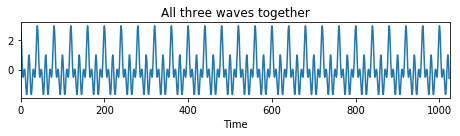

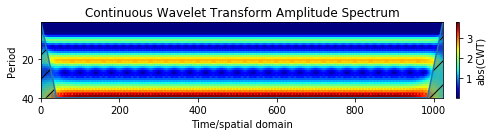

In [4]:
# generate a signal with the three waves together
allwaves = np.zeros(ns, dtype=np.float32)
for i in range(0,3):
    allwaves += np.cos(2*np.pi/periods[i]*time)

# plot the waves
fig1, ax1 = plt.subplots(1, 1, figsize=(6.5,2));  
lines = ax1.plot(allwaves); ax1.set_title("All three waves together") 
ax1.set_xlim(0, len(time)); ax1.set_xlabel("Time")
fig1.tight_layout()

# and the scaleogram
ax2 = scg.cws(allwaves, scales=scales, figsize=(7,2))
plt.tight_layout()

## Periodic variations with non sinusoidal shape

We have seen than cos waves appear as stripes on the CWT, 
let's try another periodic signal and see what' happens:
* A triangle wave with a 30s period
* With assymetry: the signal is increasing 80% of the time

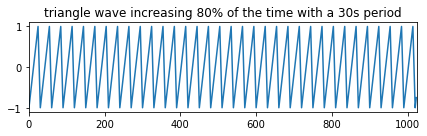

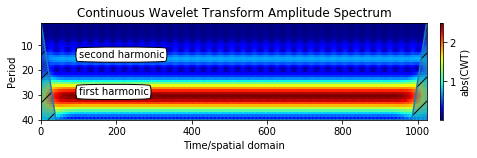

In [5]:
# build an asymetric triangle wave increasiong 80% of the time
import scipy.signal
ptri    = 30.0 # period in samples
raising = 0.8  # fraction of the period raising
triangle = scipy.signal.sawtooth(time/ptri*2*np.pi, raising)

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(6.2,2));  
lines = ax1.plot(triangle); 
ax1.set_xlim(0, len(time))
ax1.set_title("triangle wave increasing 80% of the time with a 30s period")
fig1.tight_layout()

# and the scaleogram
ax2 = scg.cws(triangle, scales=scales, figsize=(6.9,2.3)); 
txt = ax2.annotate("first harmonic", xy=(100, 30), bbox=dict(boxstyle="round4", fc="w"))
txt = ax2.annotate("second harmonic", xy=(100, 15), bbox=dict(boxstyle="round4", fc="w"))
plt.tight_layout()

A large stripe very similar to the cos wave case appear, this is the *first harmonic*.

Now a *second harmonic* is visible at exactly half the period value of the *first harmonic*. This is an expected result for periodic non sinusoidal waves. Also some fuzzy vertical features appear around the *second harmonic* which is fainter and has an amplitude of 1/4 of the first one for a triangle wave.

## How discrete events displays on a scaleogram?

The next demo signals simulates discrete events as 
* a serie of smooth spikes on the left (gaussians) with different values of sigma:
    * $2*\sigma_1 = 2$
    * $2*\sigma_2 = 10$
    * $2*\sigma_3 = 20$
* a serie of steps with different value for total width:
    * *w1 = 2*
    * *w2 = 20*
    * *w3 = 100*

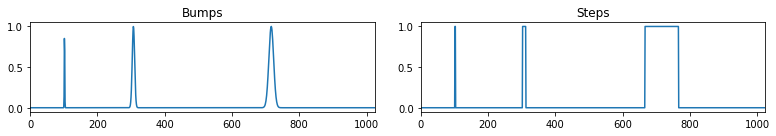

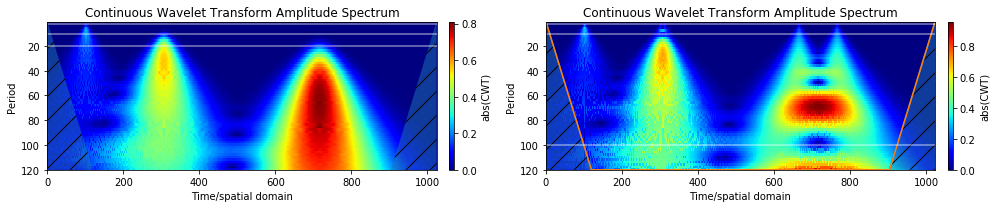

In [6]:
# several gaussian bumps given sigma
s1=1; s2=5; s3=10
events = [ns*0.1, ns*0.3, ns*0.7]
bumps = np.exp(-((time-events[0])/s1)**2) + np.exp(-((time-events[1])/s2)**2) + \
        np.exp(-((time-events[2])/s3)**2) 

# several steps given half-hidth
w1=1; w2=5; w3= 50
steps = ((time > events[0]-w1) & (time < events[0]+w1)) + \
    ((time > events[1]-w2) & (time < events[1]+w2)) + \
    ((time > events[2]-w3) & (time < events[2]+w3))

# plot the pulses
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 2)); 
ax1.set_title("Bumps"); ax2.set_title("Steps")
lines = ax1.plot(bumps); ax1.set_xlim(0, len(time))
lines = ax2.plot(steps); ax2.set_xlim(0, len(time))
fig1.tight_layout()

# and the scaleogram
scales_bumps = scg.periods2scales(np.arange(1, 120, 2) )
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14,3));  
ax3 = scg.cws(bumps, scales=scales_bumps, ax=ax3)
ax4 = scg.cws(steps, scales=scales_bumps, ax=ax4)
for bmpw, stepw in [(2*s1, 2*w1), (2*s2,2*w2), (2*s3, 2*w3)]:
    ax3.plot(ax3.get_xlim(), bmpw*np.ones(2), 'w-', alpha=0.5)
    ax4.plot(ax4.get_xlim(), stepw*np.ones(2), 'w-', alpha=0.5)
fig2.tight_layout()

Discrete events produce **cone shaped** structures on the scaleogram, that are also known as the **cone of influence**.

**Smooth spikes** (gaussians) are often closer to real data structures and build cones extending toward larger scales.
If you look at the horizontal guide lines you can see that its base is related to the approximative period in time of the bumps (*2s*, *10s*, *20s*). 
Hence a bump is similar to a periodic signal with ... one period. This example show you how wavelets are appropriate to detect *variations* localized in time.

**Steps** are much more like abnormal values for one sample (*w1*), and missing data for large number of samples (*w3*).

However the steps case is more tricky. While the first two steps are small enough to look like a gaussian bump, the large one is different.
Remember that the wavelet detects *variations in time*? Well this is that: the stepping up is considered as one variation alone at small scales as it is for the step down. Which lead to two cones with the same shape (but more energy/intensity on the Z axis) that the very short step in time.



## How noise looks like on a scaleogram?

Bellow is the result of processing gaussian noise obtained with `randn()`

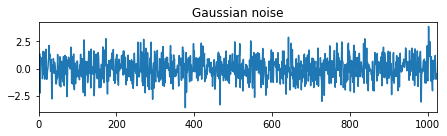

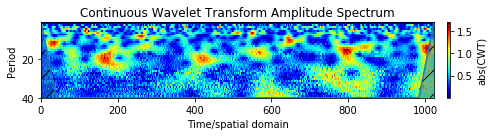

In [7]:
noise = np.random.randn(ns)

# plot the noise
fig1, ax1 = plt.subplots(1, 1, figsize=(6.2,2));  
ax1.set_title("Gaussian noise")
lines = ax1.plot(time, noise) 
ax1.set_xlim(0, ns)
fig1.tight_layout()

# and the scaleogram of noise
ax2 = scg.cws(noise, scales=scales, figsize=(7,2))
plt.tight_layout()

Noise displays usually as a patchwork of features and some bumps can look like real data features, so you have to be careful when using real data to check the level of noise when appropriate. I recommend this fairly complete paper on the [significance level](https://hal.archives-ouvertes.fr/hal-00318404/document) by *Z. Ge.* if you have some time.  
The upper plot will be different each time this notebook is run so try  by yourself! 

Now that the most common kind of signal variations have been detailed, it is time to go for the real thing!

# Analysis of a real dataset : hail to the babies!

The dataset is birth data from the CDC providing the number of children born each day with consistent filling between 1969 and 1988 included. 
* Birth rate is known to have natural seasonal variations
* It can also be influenced by many other factors like working habits
* These influences are expected at different time scales
* The impact of all these factors can also change with time

For all these reasons, multi resolution analysis is a tool of choice for this kind of data. 

Manual preliminatory analysis is available in this [starter kernel](https://www.kaggle.com/asauve/births-variation-over-the-week). The code bellow just load the data, and extract the daily number of birth per day in the 1969-1988 year range.

## First naive visualization


In [8]:
import pandas as pd
df = pd.read_csv("../input/births.csv")

# remove anomalous data (details in the starter kernel)
df = df[(df.day>=1) & (df.day<=31) & (df.births.values > 1000)]

# conversion of dates
datetime = pd.to_datetime(df[['year', 'month', 'day']], errors='coerce')
df.insert(0, 'datetime', datetime)

datetime_lim = [ df.datetime.min(), df.datetime.max() ] 
years_lim = [ df.datetime.min().year, df.datetime.max().year ]
births = df[['datetime', 'births']].groupby('datetime').sum().squeeze()

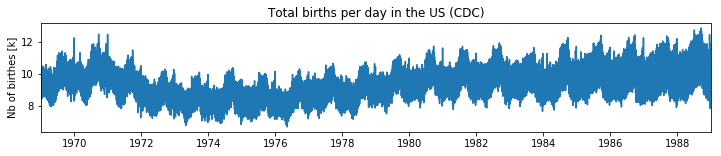

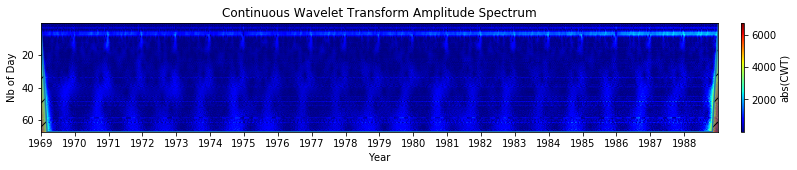

In [9]:
def set_x_yearly(ax, days, start_year=1969):
    xlim  = (np.round([0, days]) / 365).astype(np.int32)
    ticks = np.arange(xlim[0], xlim[1])
    ax.set_xticks(ticks*365)
    ax.set_xticklabels(start_year + ticks)

fig = plt.figure(figsize=(12,2))
lines = plt.plot(births.index, births.values/1000, '-')
plt.xlim(datetime_lim)

plt.ylabel("Nb of birthes [k]"); plt.title("Total births per day in the US (CDC)");
xlim = plt.xlim()

ax = scg.cws(births, figsize=(13.2, 2), xlabel="Year", ylabel="Nb of Day")
set_x_yearly(ax, len(births))

**Observations**
* births per day  : The birth data shows periodic features as expected at the year scales and smaller ones
* Scaleogram : This first scaleogram is not very impressive. Still an horizontal line shows up at about 7 days periodicity

High values do appear near the bordersof the scaleogram which are a normal behaviour of the wavelet processing. These effects are well known as the *cone of influence*, this is why an (optional) mask is overplot on this area.

## Normalization

Removing the mean value is mandatory, otherwise the borders of the data are considered as *steps* which create a lot of spurious cone shaped detection.

After removal of the mean value (no scaling) the scaleogram looks like:

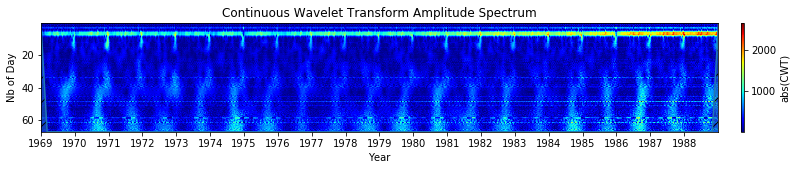

In [10]:
births_normed = births-births.mean()
ax = scg.cws(births_normed, figsize=(13.2, 2), xlabel="Year", ylabel="Nb of Day")
set_x_yearly(ax, len(births))

## Adjusting the scales

The amplitude range of the color map (Z axis) is now set with the `clim=(0,2500)` parameter. The exact value for the amplitude of variations is dependent of the wavelet but will stay close to the order of the real value, see the cos wave plot for hints.

To see the yearly features an appropriate scales range is generated with `period2scales()`.

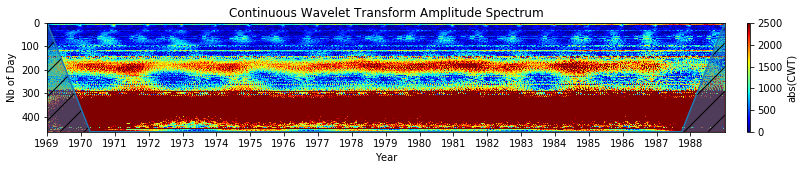

In [11]:
scales = scg.periods2scales(np.arange(1, 365+100, 3))
ax = scg.cws(births_normed, scales=scales, figsize=(13.2, 2), xlabel="Year", ylabel="Nb of Day",
            clim=(0, 2500))
set_x_yearly(ax, len(births))

This is much better, we now see very well a yearly variation and also an approximately 6 month one! 

However now the small scale weekly variations are invisible.


## Using logaritmic scale

To be able to see the small periods and the large ones at once, it is better to use logarithmic scale on the Y axis. This is achieved with the `yscale='log'`option.

Number of available days: 7305


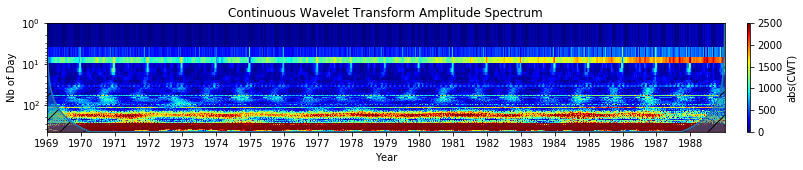

In [12]:
scales = scg.periods2scales(np.arange(1, 365+100, 3))
ax = scg.cws(births_normed, scales=scales, figsize=(13.2, 2), xlabel="Year", ylabel="Nb of Day", 
             clim=(0,2500), yscale='log')
set_x_yearly(ax, len(births))
print("Number of available days:", len(births_normed))

The result is much better, but now the pixels at low periods values are elongated along the Y axis. 

In order to get an homogenous definition on the *scaleogram*, the period values have to be evenly spaced in *log space* then converted to scale values as shown bellow:

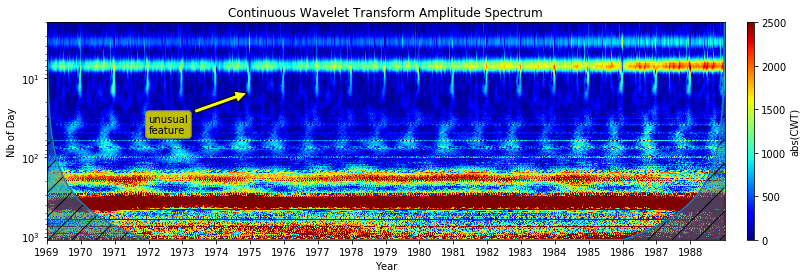

In [13]:
# use logaritmic spaced scales values when using log-Y-axis :-)
scales = scg.periods2scales(np.logspace(np.log10(2), np.log10(365*3), 200))

# store the CWT in an object to avoid recomputation for next plots
cwt = scg.CWT(births_normed, scales=scales) 

ax  = scg.cws(cwt, figsize=(13.2, 4), xlabel="Year", ylabel="Nb of Day", 
             clim=(0,2500), yscale='log')
set_x_yearly(ax, len(births))

bboxf = dict(boxstyle="round", facecolor="y", edgecolor="0.5")
arrowpropsf = dict(facecolor='yellow', shrink=0.05)
text = ax.annotate("unusual\nfeature", xy=(365*6, 15), xytext=(365*3, 50), 
                   bbox=bboxf, arrowprops=arrowpropsf)


OK now we can see signal variations at all scales. A feature is appealing on the weekly stripe, it shows each years at the same period, so let's have a closer look to distinguish if it is a real feature or an artefact from missing data?  

## Zoom on the feature

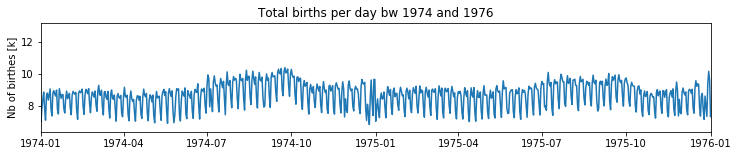

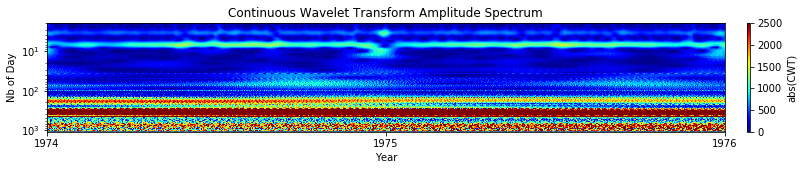

In [14]:
# zoom on two years:  1974-1976
fig = plt.figure(figsize=(12,2))
lines = plt.plot(births.index, births.values/1000, '-')
plt.xlim(pd.to_datetime("1974-01-01"), pd.to_datetime("1976-01-01"))
plt.ylabel("Nb of birthes [k]"); plt.title("Total births per day bw 1974 and 1976");

# replot previous scaleogram with zoom
ax  = scg.cws(cwt, figsize=(13.2, 2), xlabel="Year", ylabel="Nb of Day", 
             clim=(0,2500), yscale='log')
set_x_yearly(ax, len(births))
xlim = ax.set_xlim( (1974-1969)*365, (1976-1969)*365 )

On first sight a weekly patterns appears to be very regular, but something happens around christmas, let zoom again on this period:

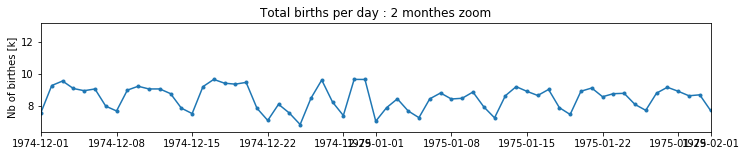

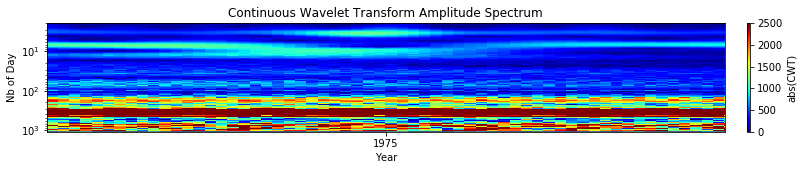

In [15]:
# zoom on two monthes:  December 1975 and January 1976
fig = plt.figure(figsize=(12,2))
lines = plt.plot(births.index, births.values/1000, '.-')
plt.xlim(pd.to_datetime("1974-12-01"), pd.to_datetime("1975-02-01"))
plt.ylabel("Nb of birthes [k]"); plt.title("Total births per day : 2 monthes zoom");

# replot previous scaleogram with zoom
ax  = scg.cws(cwt, figsize=(13.2, 2), xlabel="Year", ylabel="Nb of Day", 
             clim=(0,2500), yscale='log')
set_x_yearly(ax, len(births))
xlim = ax.set_xlim( (1975-1969)*365-30, (1975-1969)*365+30 )

Now it's clear the suspect looks like an end-of-year effect:
* Christmas: the 23/24/25 December shows abnormally low number of births and these days depart from the weekly pattern
* The [starter kernel](https://www.kaggleusercontent.com/kf/12226085/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..sg37wxxpESt5qPN4cj_xTw.dlanSYjQUrjzh2rRGbtqiX1m7e8ykg1nucKJEl50aT2odhsMGTUsc_TwkBH5Jlw6GKGnRiXl1qhqJh4CGzlY_B79mrmHO6V0N4h9_4_TqVTEYxbqQFlNmJJjM2-hkgIxsQtj0wXu_Vhvse772UwlTnk-zxtp_5z-cxFIcACGiYg.aTIWJ-KWMoRHslUTFSJqfg/__results__.html#Check-monthes-with-abnormal-birth-values) does not show missing data for December, which is consistent with the presence of some value for the affected dates
* The 1st and 2nd of january are also affected which is understandable as there are usually less personnal available on these dates

## Synthesis

The scaleogram has been 
* Built from normalized data (mean removal)
* Log-scaled to be more readable at all scales

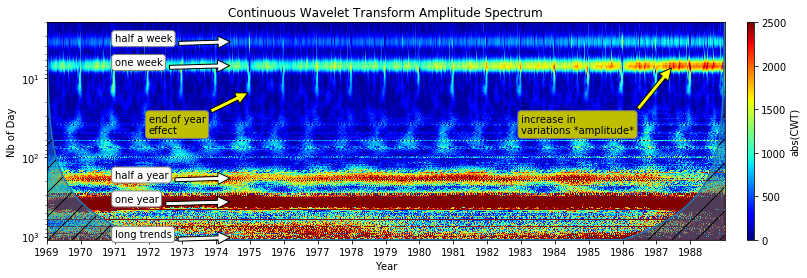

In [16]:
ax  = scg.cws(cwt, figsize=(13.2, 4), xlabel="Year", ylabel="Nb of Day", 
             clim=(0,2500), yscale='log')
set_x_yearly(ax, len(births))

bbox = dict(boxstyle="round", facecolor="w", edgecolor="0.5")
bbox2 = dict(boxstyle="round", facecolor="y", edgecolor="0.5")
arrowprops = dict(facecolor='white', shrink=0.05)
arrowprops2 = dict(facecolor='yellow', shrink=0.05)
for period, label in [ (3.5, "half a week"), (7, "one week"), (365/2, "half a year"), 
                      (365, "one year"), (365*2.8, "long trends")]:
    text = ax.annotate(label, xy=(365*5.5, period), xytext=(365*2, period), 
                       bbox=bbox, arrowprops=arrowprops)
text = ax.annotate("end of year\neffect", xy=(365*6, 15), xytext=(365*3, 50), 
                   bbox=bbox2, arrowprops=arrowprops2)
text = ax.annotate("increase in\nvariations *amplitude*", xy=(365*18.5, 7), xytext=(365*14, 50), 
                   bbox=bbox2, arrowprops=arrowprops2)

The CWT reveals a lot of information in a short amount of time:
* A weekly variation showing the habits in the hospitals is present over several decades
  * A second stripe at half a week is expected as the weekly patter is not an axact cosinus
  * An increase in the weekly pattern is visible in the 80's which can be either caused by a change in the work habits of the hospitals, a change in birthrate or simple variation of the population
* A strong yearly trend is present which is a well known seasonal variation in the birthrates, humans are visibly prone to it ;)
  * A second stripe at half a year is clearly a second harmonic
  * Fuzzy patterns appears in the 3 to 1 month zone that could be due to a third harmonic, as tha yearly variation are so strong. It may also be caused by holiday impact on birth rate and may need further study
* An end-of-year effect has been spotted around christmas and January the 1st. This one may have remained unseen with other frequency based method.




# Conclusions

In this notebook we have seen how the basic kind of signal variations translate onto
a scaleogram. Next an example time ordered dataset has been used to demonstrate step
by step how the CWT apply to standard data.

The same methodology can be extended to network traffic analysis to detect unusual behaviours. Try by yourself on your favorite time/space ordered dataset. The CWT is a powerful tool that is growingly used as input for neural networks and can be usedto create new features for classification or anomaly detection.

I did not dive into the variety of wavelet function that can be chosen depending on the property of your signal. Still you can change the `set()` value at the top of this notebook to try other functions like `mexh` or `gaus5`. 

Have fun and plussify if you liked this ;-) !


# See also 

[PyWAvelets](https://pywavelets.readthedocs.io/en/latest/) A fairly complete wavelet library in python

[scaleogram](https://github.com/alsauve/scaleogram) the visualization tool used in this notebook

[A Practical Guide to Wavelet Analysis ](https://journals.ametsoc.org/doi/pdf/10.1175/1520-0477%281998%29079%3C0061%3AAPGTWA%3E2.0.CO%3B2) - The reference paper for wavelet analysis by Christopher Torrence and Gilbert P. Compo

[Continuous Wavelet Transform (CWT)](https://www.weisang.com/fr/dokumentation/timefreqspectrumalgorithmscwt_fr/) - To check frequency views of wavelet pulses, on weisang.com

[How the scale parameter relates to period and frequency?](https://github.com/alsauve/scaleogram/blob/master/doc/scale-to-frequency.ipynb) - For basic conversion between scales and time/frequency domain values by A. Sauve

[Significance tests for the wavelet power and the wavelet
power spectrum](https://hal.archives-ouvertes.fr/hal-00318404/document) A statistically well founded paper by Z. Ge.